# Prática usando SVM

O objetivo desse projeto é analisar o dataset Heart Faliure Clinical Records do UCI Machine Learning Repository e classificar se um paciente sobreviveu ou não de acordo com os dados fornecidos, usando o SVM (Support Vector Machines).

## Importação das Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

## Visualização do Dataset

In [2]:
df = pd.read_csv('dataset/heart_failure.csv')
X = df.drop(columns=['DEATH_EVENT'], axis=1)
y = df['DEATH_EVENT']

In [3]:
X.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8


In [4]:
y.value_counts()

DEATH_EVENT
0    203
1     96
Name: count, dtype: int64

## Pré procesamento

In [6]:
df.isnull().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

In [7]:
df.duplicated().sum()

np.int64(0)

## Split Train-Test

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43) 

In [9]:
train_index = X_train.columns
train_index

Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time'],
      dtype='object')

## Parte 1: Análise Utilizando Feature Selection

In [10]:
from sklearn.feature_selection import mutual_info_classif
mutual_info = mutual_info_classif(X_train, y_train)
mutual_info = pd.Series(mutual_info)
mutual_info.index = train_index
mutual_info.sort_values(ascending=False)

time                        0.237912
ejection_fraction           0.096351
age                         0.069128
high_blood_pressure         0.034687
serum_creatinine            0.022869
anaemia                     0.009605
creatinine_phosphokinase    0.009127
sex                         0.008980
diabetes                    0.005792
platelets                   0.000000
serum_sodium                0.000000
smoking                     0.000000
dtype: float64

<Axes: >

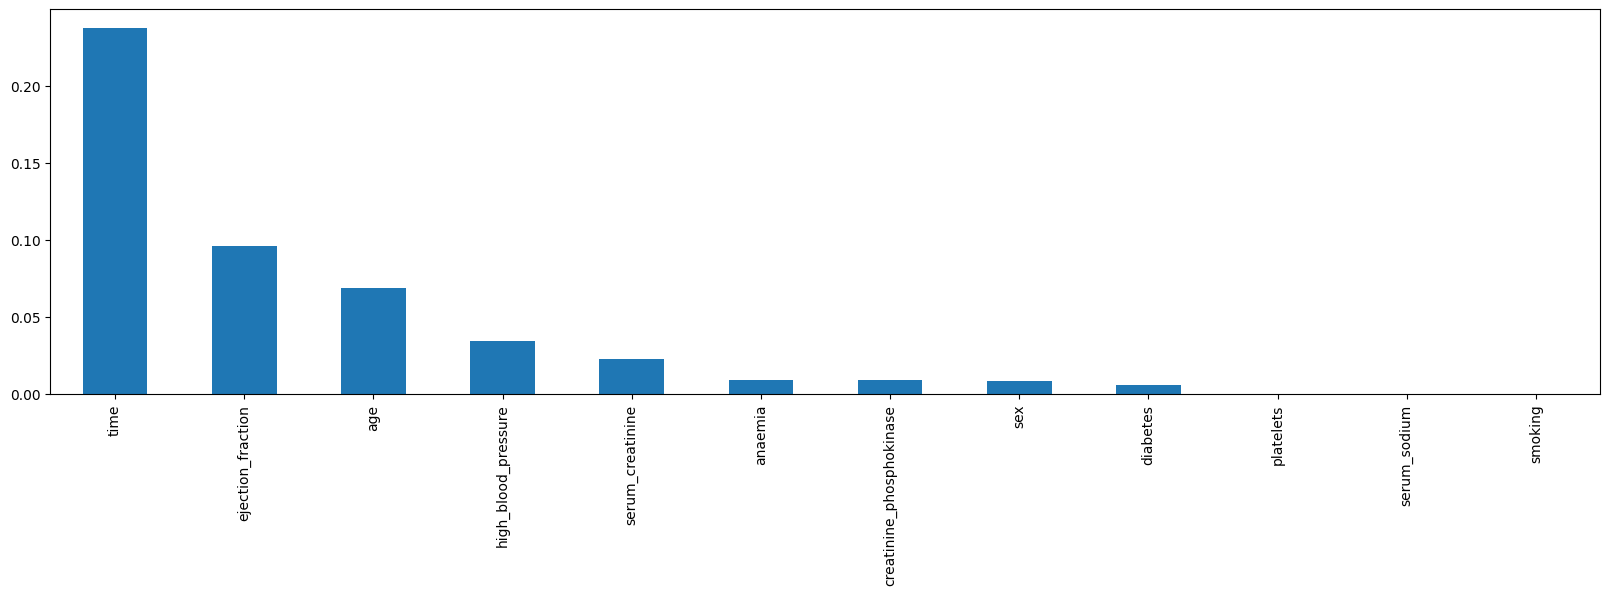

In [11]:
mutual_info.sort_values(ascending=False).plot.bar(figsize=(20, 5))

In [12]:
from sklearn.feature_selection import SelectKBest
Select_features = SelectKBest(mutual_info_classif, k=7)
Select_features.fit(X_train, y_train)
train_index[Select_features.get_support()]

Index(['age', 'creatinine_phosphokinase', 'diabetes', 'ejection_fraction',
       'serum_creatinine', 'sex', 'time'],
      dtype='object')

In [13]:
columns = ['age', 'creatinine_phosphokinase', 'ejection_fraction',
       'high_blood_pressure', 'serum_creatinine', 'smoking', 'time']

X_train=X_train[columns]
X_test=X_test[columns]

In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['rbf', 'poly']
}
grid = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1],
                         'kernel': ['rbf', 'poly']},
             scoring='accuracy')

In [18]:
grid.best_params_

{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}

In [13]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

def eval_metric(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)
    
    print("Test_Set")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print()
    print("Train_Set")
    print(confusion_matrix(y_train, y_train_pred))
    print(classification_report(y_train, y_train_pred))


In [ ]:
eval_metric(grid, X_train, y_train, X_test, y_test)

Test_Set
[[30  4]
 [ 6 20]]
              precision    recall  f1-score   support

           0       0.83      0.88      0.86        34
           1       0.83      0.77      0.80        26

    accuracy                           0.83        60
   macro avg       0.83      0.83      0.83        60
weighted avg       0.83      0.83      0.83        60


Train_Set
[[162   7]
 [ 19  51]]
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       169
           1       0.88      0.73      0.80        70

    accuracy                           0.89       239
   macro avg       0.89      0.84      0.86       239
weighted avg       0.89      0.89      0.89       239



## Parte 2: Análise Utilizando Heatmap

### Criação do Heatmap

<Axes: >

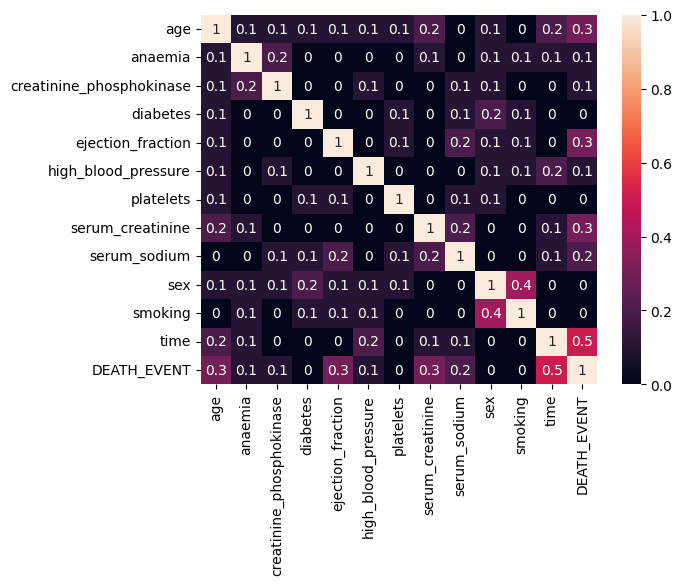

In [5]:
# Primeiro é calculada a correlação dos dados usando a função corr() que usa Pearson, analisando se existe alguma correlação linear
# Depois a gente faz o absoluto e arredonda o valor em uma casa decimal

sns.heatmap(df.corr().abs().round(1), annot=True)

Ao analisar os resultados do heatmap, podemos afirmar que não existe muita correlação linear entre os dados, então provavelmente será melhor utilizar o RBF.

A seguir vamos analisar as combinações de alguns desses atributos.

### Teste 1: Análise com 2 Atributos

A princípio vamos analisar os atributos **ejection_fraction** e **time**, pois possuem o maior nível de correlação com o y (DEATH_EVENT). Mas esses atributos possuem nenhuma correlação entre si. 

In [6]:
# Separar os atributos

X2 = X[['ejection_fraction', "time"]]
X2.head()

,ejection_fraction,time
0,20,4
1,38,6
2,20,7
3,20,7
4,20,8


In [7]:
# Confirmando a quantidade

X2.shape

(299, 2)

#### Split Train-Test

In [8]:
# Divisão dos dados das 2 colunas entre treino e teste

from sklearn.model_selection import train_test_split

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, test_size=0.2, random_state=43)

#### Normalização dos Dados

In [ ]:
# Normalizando os dados de treino e teste pois o SVM é sensível a escala
# Adicionei em uma função para que ficasse mais fácil de reutilizar

from sklearn.preprocessing import StandardScaler

def scaling(X_train, X_test):
    """
    Normaliza os valores de X para treino e teste.
    """
    scaler = StandardScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return (X_train, X_test)

X2_train, X2_test = scaling(X2_train, X2_test)

#### Treinamento do Modelo usando Grid Search e Cross Validation

In [10]:
# Realiza uma busca exaustiva para determinar quais os melhores parâmetros para um modelo
# Ele também aplica o cross validation, a quantidade de folds desse caso é 5
# Adicionei em uma função para que ficasse mais fácil de reutilizar

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

def grid_model(X_train, y_train):
    """
    Recebe os valores de X e y, realizando o treinamento com SVC (versão do SVM para classificação).
    Além disso, ele usa cross validation para evitar overfitting e o grid search para buscar os melhores parâmetros
    """
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': [0.001, 0.01, 0.1, 1],
        'kernel': ['rbf', 'poly']
    }

    grid = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy')
    grid.fit(X_train, y_train)

    return grid

grid = grid_model(X2_train, y2_train)

In [11]:
# Para conseguir os melhores parâmetros

grid.best_params_

{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}

In [ ]:
# Essa função foi reutilizada da parte 1, ela exibe as matrizes de confusão dos dados de treino e de teste, e calcula precisão, recall, f1-score, acurácia

eval_metric(grid, X2_train, y2_train, X2_test, y2_test)

Test_Set
[[32  2]
 [ 9 17]]
              precision    recall  f1-score   support

           0       0.78      0.94      0.85        34
           1       0.89      0.65      0.76        26

    accuracy                           0.82        60
   macro avg       0.84      0.80      0.80        60
weighted avg       0.83      0.82      0.81        60


Train_Set
[[160   9]
 [ 24  46]]
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       169
           1       0.84      0.66      0.74        70

    accuracy                           0.86       239
   macro avg       0.85      0.80      0.82       239
weighted avg       0.86      0.86      0.86       239



#### Plots

In [18]:
from sklearn.metrics import roc_curve, roc_auc_score

In [ ]:
# Como é uma situação de classificação binária, podemos ilustrar a curva ROC do modelo e a área sob a curva (ROC AUC)
# A curva ROC é a comparação da taxa de verdadeiros positivos com a taxa de falsos positivos.
# O AUC por sua vez determina a probabilidade do modelo de classificar positivo

def curva_ROC(y_pred, y_test):
    """
    Faz o gráfico da curva ROC e cálcula a área sob a curva (AUC ROC) usando as predições do modelo nos dados de teste e os valores de y para o teste.
    """
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr, label=f"SVM (AUC = {roc_auc_score(y_test, y_pred):.2f})") 

    plt.xlabel('Taxa de Falsos Positivos (FPR)') 
    plt.ylabel('Taxa de Verdadeiros Positivos (TPR)') 
    plt.title('Curva ROC') 
    plt.legend()

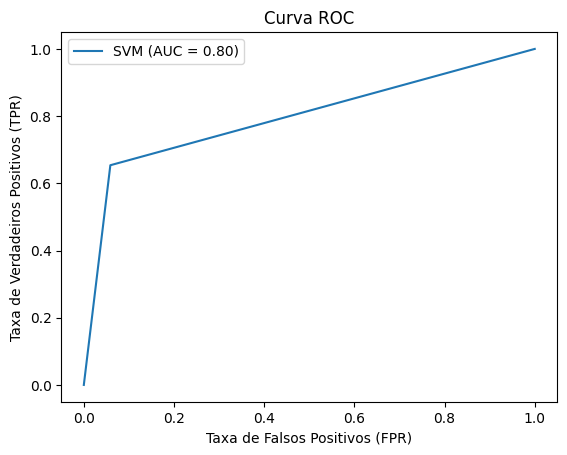

In [24]:
y2_pred = grid.predict(X2_test)
curva_ROC(y2_pred, y2_test)

O resultado do AUC mostra que o modelo está com um bom desempenho do qual está muito provavelmente prevendo os resultados da forma certa do que fazendo escolhas aleatórias.